In [1]:
!pip install gensim==3.8.3

     |████████████████████████████████| 24.2 MB 424 kB/s            
  Attempting uninstall: gensim
    Found existing installation: gensim 4.0.1
    Uninstalling gensim-4.0.1:
      Successfully uninstalled gensim-4.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scattertext 0.1.5 requires gensim>=4.0.0, but you have gensim 3.8.3 which is incompatible.


# This is Mohamed Fawzy solving challenge 2
**Let us go through details**.

In [2]:

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout , Embedding
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


After importing all necessary libs I read data that I collected from 
1 - http://saifmohammad.com/WebPages/TweetEmotionIntensity-dataviz.html
2 - https://github.com/cardiffnlp/tweeteval

Thanks to this paper 

3 - https://onlinelibrary.wiley.com/doi/full/10.1002/eng2.12189

Let's read Tweetval data first which has two sectors : 


1- data for Emotions classes: Joy, Fear, Anger, Optimistic


2- another dataset that has classes: Positive , Negative , Neutral

In [3]:
X_train = pd.read_csv('../input/tweeteval/train_text.txt',header=None,sep="\n")
y_train = pd.read_csv('../input/tweeteval/train_labels.txt',header=None,sep="\n")
X_val = pd.read_csv('../input/tweeteval/val_text.txt',header=None,sep="\n") 
y_val =  pd.read_csv('../input/tweeteval/val_labels.txt',header=None,sep="\n")
X =  pd.concat([X_train, X_val])

y = pd.concat([y_train,y_val])              

X.head(50)

,0
0,“Worry is a down payment on a problem you may ...
1,My roommate: it's okay that we can't spell bec...
2,No but that's so cute. Atsu was probably shy a...
3,Rooneys fucking untouchable isn't he? Been fuc...
4,it's pretty depressing when u hit pan on ur fa...
5,@user but your pussy was weak from what I hear...
6,Making that yearly transition from excited and...
7,Tiller and breezy should do a collab album. Ra...
8,@user broadband is shocking regretting signing...
9,@user Look at those teef! #growl


After that we'll unify column names for future concatenation

In [4]:
X.rename(columns={0:"text"},inplace=True)
y.rename(columns={0:"label"},inplace=True)
df = pd.concat([X,y],axis=1)
df.head()

,text,label
0,“Worry is a down payment on a problem you may ...,2
1,My roommate: it's okay that we can't spell bec...,0
2,No but that's so cute. Atsu was probably shy a...,1
3,Rooneys fucking untouchable isn't he? Been fuc...,0
4,it's pretty depressing when u hit pan on ur fa...,3


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

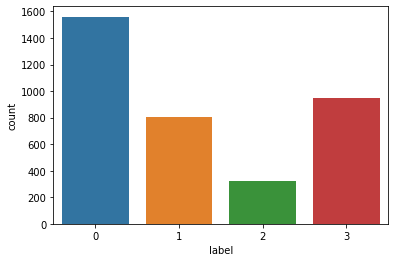

In [5]:
sns.countplot(df['label'])

Looks like our data is skewed ... that's why I chose gathering up my data.

0 stands for "Anger" 
1 stands for "Joy"
2 stands for "Optimistic"
3 stands for "Sadness" as mentioned in data manual

So... we're dropping label (2)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

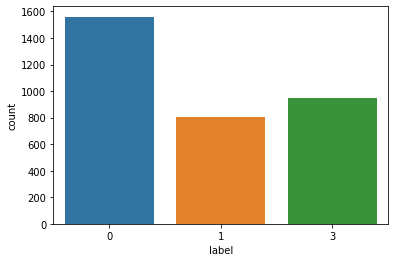

In [6]:
df = df[df.label != 2]
val_count = df['label'].value_counts()
sns.countplot(df['label'])

Let's join some tweets from the second section which have label ("Neutral") in it.

In [7]:
neutralx=pd.read_csv('../input/tweetevalsentiment/train_text.txt',header=None,sep="\n")
neutraly= pd.read_csv('../input/tweetevalsentiment/train_labels.txt',header=None,sep="\n")
neutralx.rename(columns={0 : "text"}, inplace = True)
neutraly.rename(columns={0: "label"},inplace = True)
neutral = pd.concat([neutralx,neutraly], axis = 1)
neutral = neutral.loc[neutral['label'] == 1]
neutral.info()
neutral.tail(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20673 entries, 1 to 45614
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16436 non-null  object
 1   label   20673 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 484.5+ KB


,text,label
45597,NaN,1
45598,NaN,1
45599,NaN,1
45602,NaN,1
45603,NaN,1
45605,NaN,1
45608,NaN,1
45609,NaN,1
45613,NaN,1
45614,NaN,1


In [8]:
neutral.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
neutral.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16436 entries, 1 to 36371
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16436 non-null  object
 1   label   16436 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 385.2+ KB


In [9]:
neutral.label = 2
neutral.head()

,text,label
1,Ben Smith / Smith (concussion) remains out of ...,2
2,Sorry bout the stream last night I crashed out...,2
3,Chase Headley's RBI double in the 8th inning o...,2
9,@user @user CENA & AJ sitting in a tree K-I-S-...,2
10,@user Well said on HMW. Can you now address wh...,2


In [10]:
neutral = neutral.sample(n = 3000)
#I got only 3000 records to avoid label domination and I will add more data to all other classes in the future.
neutral.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 25888 to 16383
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3000 non-null   object
 1   label   3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 70.3+ KB


In [11]:
df = pd.concat([df,neutral])

In [12]:
df = df.sample(frac=1)
df.tail()

,text,label
2418,#GBBO is such a homely pure piece of tv gold. ...,0
114,@user Eduardo without injury was honestly amaz...,3
538,"When you wake up, scroll through social media,...",3
1685,Watched tna for the first time in a long time ...,3
13449,@user I'm about that Xbox life fam. But I'm th...,2


Now we got our data with ("Neutral") class

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

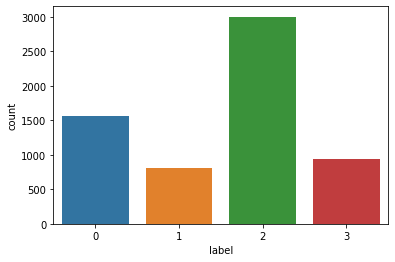

In [13]:
sns.countplot(df['label'])

I did clean this data before using Excel (Attached more details)

In [14]:
df2=pd.read_csv('../input/tweets-csv/Tweetsclean.csv')
df2.Sentiment.unique()

array(['anger', 'unknown', 'fear', 'joy', 'sadness'], dtype=object)

In [15]:
df2=df2[['Tweet','Sentiment']]

From my very little experience: String labels are not the best for keras models.

In [16]:
df2['Sentiment'].mask(df2['Sentiment'] == "anger" , 0, inplace=True)
df2['Sentiment'].mask(df2['Sentiment'] == "joy" , 1, inplace=True)
df2['Sentiment'].mask(df2['Sentiment'] == "sadness" , 3, inplace=True)
df2.Sentiment.unique()


array([0, 'unknown', 'fear', 1, 3], dtype=object)

Now let's takeout classes that we won't use in our model

In [17]:
df2 = df2[df2.Sentiment != "fear"]
df2 = df2[df2.Sentiment != "unknown"]
df2.Sentiment.unique()

array([0, 1, 3], dtype=object)

In [18]:
df2.head()

,Tweet,Sentiment
0,How the fu*k! Who the heck! moved my fridge!.....,0
1,So my Indian Uber driver just called someone t...,0
2,@DPD_UK I asked for my parcel to be delivered ...,0
3,so ef whichever butt wipe pulled the fire alar...,0
4,Don't join @BTCare they put the phone down on ...,0


Again I'm unifing Dataframe structure for future concatenation

In [19]:
df2.rename(columns={"Tweet":"text","Sentiment": "label"},inplace=True)
df.head()

,text,label
207,Alright Alex and I have party boy neighbors wh...,1
31555,This is Buffon\u2019s 122nd cap for Italy\u002...,2
2772,@user Democrats and their voters have zero tol...,0
29269,@user Happy Birthday Beyonce #Salutejayz may y...,2
1790,"@user Luckii, I'm changing in so many ways bc ...",1


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6309 entries, 207 to 13449
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6309 non-null   object
 1   label   6309 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 405.9+ KB


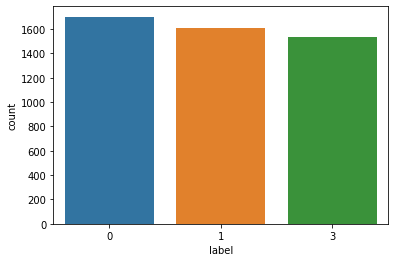

In [20]:
sns.countplot(df2['label'])
df.info()

I think I'm pretty lucky this time ... data is not skewed and beatifully balanced

In [21]:
df = pd.concat([df,df2])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11152 entries, 207 to 7096
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11152 non-null  object
 1   label   11152 non-null  object
dtypes: object(2)
memory usage: 261.4+ KB


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

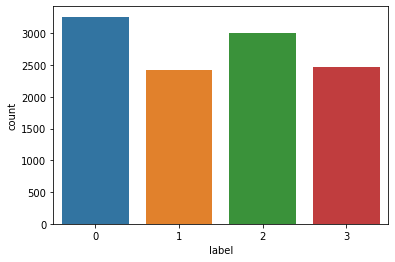

In [22]:
sns.countplot(df['label'])

This is the final result of our data. Now let's shuffle it

In [23]:
df=df.sample(frac=1)

In [24]:
df.to_csv("mftweets.csv")

Now time for stop words: words that people use as fillers in their text such as pronounces or tenses: he, his, will, had... etc 

Stemming is finding the root of the word like : Playing > Play

In [25]:
sw = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [26]:
re_cleaner = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
userPattern = "@[^\s]+"

In [27]:
def preprocess(text, stem=False):
  text = re.sub( userPattern , 'USER ',str(text))
  text = re.sub(re_cleaner, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in sw:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

If a tweet looked like this :  @MohamedFawzy has always wanted to work as a data scientist! 

Now it will look like : USER want work data scientist

In [28]:
df.text = df.text.apply(lambda x: preprocess(x))
df.tail(50)

,text,label
1386,literally dying amp living time catch user twi...,1
113,wow snap cnnmoney,1
6124,user yea lol catchy fret,3
5280,lord jesus want prison want free entice heart ...,1
29867,1st song day know better frank ocean normal sh...,2
17139,like electable leader labour party tony blair,2
932,moving clips youtube tonight vigil held tulsa ...,3
321,another joyful encounter tribez amp castlez me...,1
3120,season 3 penny dreadful netflix well afternoon...,1
5757,user 2 wait 48 hours call back cancel order pl...,3


In [29]:
print("Sentiments shape : ",df.label.shape)

Sentiments shape :  (11152,)


In [30]:
train, test = train_test_split(df, test_size=0.1 ,random_state=47) 
print("Train Data size:", len(train))
print("Test Data size", len(test))

Train Data size: 10036
Test Data size 1116


From here ... I started seeking help choosing the best hyperparamters for my data ... this notebook helped me a lot!
https://www.kaggle.com/code/paoloripamonti/twitter-sentiment-analysis

Started turning my text data to 1D vector each tweet ...
Let's setup parameters in one place

In [31]:
documents = [_text.split() for _text in train.text] 
W2V_SIZE = 100
W2V_WINDOW = 7
W2V_EPOCH =128
W2V_MIN_COUNT = 10
SEQUENCE_LENGTH = 100
EPOCHS = 12
BATCH_SIZE = 1024

This Github repository of Gensim also helped me a lot!
https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4#7-methods-like-most_similar-wmdistance-doesnt_match-similarity--others-moved-to-keyedvectors

In [32]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [33]:
w2v_model.build_vocab(documents)

In [34]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 1866


In [35]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(8666526, 14148224)

In [36]:
w2v_model.wv.most_similar("love")

[('miss', 0.36200612783432007),
 ('make', 0.3126246929168701),
 ('expensive', 0.2833516597747803),
 ('put', 0.28101852536201477),
 ('face', 0.2679109275341034),
 ('losing', 0.2648250460624695),
 ('good', 0.25606828927993774),
 ('meal', 0.2547922134399414),
 ('success', 0.24836105108261108),
 ('truly', 0.24554061889648438)]

Looks like our word 2 vector model worked... Now let's tokenize our data to get output for each token

In [37]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.text)
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 17033


Now let's pad each tweet with a list of zeroes to make max sequence  = 100 

In [38]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train.text),
                        maxlen = SEQUENCE_LENGTH )
x_test = pad_sequences(tokenizer.texts_to_sequences(test.text),
                       maxlen = SEQUENCE_LENGTH )

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (10036, 100)
Testing X Shape: (1116, 100)


Now since we have only 4 categories so ... no problem for one hot encoding

In [39]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(train.label, 4)
y_test = to_categorical(test.label, 4)
print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (10036, 4)
y_test (1116, 4)


In [40]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (10036, 100)
y_train (10036, 4)
x_test (1116, 100)
y_test (1116, 4)


In [41]:
print(vocab_size,W2V_SIZE,len(words))
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

17033 100 1866
(17033, 100)


Embedding layer enables us to convert each word into a fixed length vector of a certain size.

In [42]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

Now ... network I actually found it online while searching for the best LSTM network for Sentiment Prediciton and here's what I got after tweaking it to be suitable with my case

In [43]:
sequence_input = Input(shape=(SEQUENCE_LENGTH), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(4, activation='softmax')(x)
model = tf.keras.Model(sequence_input, outputs)

2022-03-18 20:36:47.695474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 20:36:47.821357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 20:36:47.822466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 20:36:47.824090: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [44]:
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [45]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

Training Time

In [46]:
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

2022-03-18 20:36:52.445391: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/12


2022-03-18 20:36:59.334899: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


9/9 [==============================] - 24s 1s/step - loss: 1.2856 - accuracy: 0.4143 - val_loss: 1.0663 - val_accuracy: 0.5239
Epoch 2/12
9/9 [==============================] - 12s 1s/step - loss: 1.0373 - accuracy: 0.5414 - val_loss: 0.9156 - val_accuracy: 0.6096
Epoch 3/12
9/9 [==============================] - 11s 1s/step - loss: 0.9059 - accuracy: 0.6143 - val_loss: 0.8223 - val_accuracy: 0.6584
Epoch 4/12
9/9 [==============================] - 11s 1s/step - loss: 0.8385 - accuracy: 0.6561 - val_loss: 0.7876 - val_accuracy: 0.6853
Epoch 5/12
9/9 [==============================] - 12s 1s/step - loss: 0.7861 - accuracy: 0.6767 - val_loss: 0.7545 - val_accuracy: 0.6922
Epoch 6/12
9/9 [==============================] - 11s 1s/step - loss: 0.7415 - accuracy: 0.7005 - val_loss: 0.7274 - val_accuracy: 0.7032
Epoch 7/12
9/9 [==============================] - 11s 1s/step - loss: 0.7077 - accuracy: 0.7147 - val_loss: 0.7022 - val_accuracy: 0.7131
Epoch 8/12
9/9 [=============================

In [47]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

2/2 [==============================] - 0s 95ms/step - loss: 0.5828 - accuracy: 0.7670

ACCURACY: 0.7670251131057739
LOSS: 0.5828273892402649


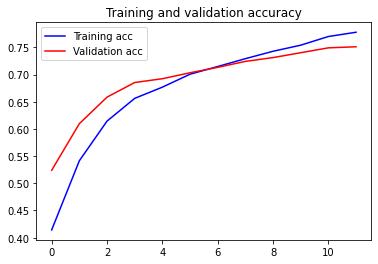

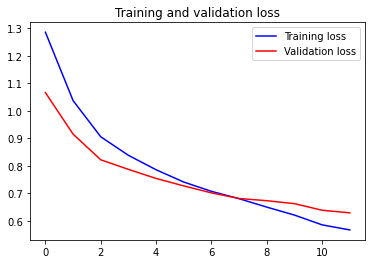

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [49]:
model.save("Sentiment Analysis v2")
w2v_model.save("WORD2VEC_Sentiment Analysis V2")

2022-03-18 20:40:26.160607: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


That's it for now ... I've learned a lot through this challenge. I hope you admire my work. Thanks!